# Audio Recoginition 4C16/5C16 Project

## Audio Content & Gender Classification

#### About the dataset

The dataset consists of 25k audio tracks. Each of the audio track records the waveform of an audio recording of a human reading out digit (ie. from 0-9). Your task is to train two classification neural networks that **identify the digit** that has been uttered and **identify the gender**.

The dataset has already been prepared to numpy files and is in the 'dataset' directory and is of the following structure:

- *dataset/*
    - *input.npy*
    - *gender.npy*
    - *digit.npy*

The *input.npy* has a shape of (25000, 8000) which indicates 25000 waveforms and 8000 samples from each waveform. Each waveform is normalised with 1 second duration and 8 kHz sampling frequnecy. The *gender.npy* and *digit.npy* files contains the correspondent target information of the 25000 waveforms in the same order.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/4c16-labs/code/lab-07/

In [ ]:
# Download the dataset
!curl --create-dirs -o /home/tcd/data/audiowavform-dataset.tar.xz https://tcddeeplearning.blob.core.windows.net/deeplearning202324/audiowavform-dataset.tar.xz
# Extract the dataset
!mkdir /home/tcd/data/audiowavform
!tar -xvf /home/tcd/data/audiowavform-dataset.tar.xz -C /home/tcd/data/audiowavform

# Dataset location: /home/tcd/data/audiowavform/public

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  108M  100  108M    0     0  7495k      0  0:00:14  0:00:14 --:--:-- 7120k
mkdir: cannot create directory ‘/home/tcd/data/audiowavform’: File exists
public/
public/ytrain_num.npy
public/ytrain_gender.npy
public/xtrain.npy


In [ ]:
import os
import scipy
import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from skimage.transform import resize

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
import tensorflow as tf
import sklearn as skl
from sklearn.model_selection import cross_val_score

from IPython.display import clear_output
from matplotlib.ticker import MaxNLocator

seed = 42


In [ ]:
# loading the datasets in memory

dataset_path = '/home/tcd/data/audiowavform/public'

# xtrain  : numpy array of size n x 8000 which contains the waveforms for each of the 25k audio files.
x = np.load(f'{dataset_path}/xtrain.npy')

# y_num   : numpy array of size n x 10 which contains the digits (as one-hot encoding of the 10 categories) for each of the 25k audio files.
y_num = np.argmax(np.load(f'{dataset_path}/ytrain_num.npy'), axis=-1)
y_num_1 = np.load(f'{dataset_path}/ytrain_num.npy')

# y_gender: numpy array of size n x 2 which contains the gender (as one-hot encoding of the 2 categories) for each of the 25k audio files.
y_gender = np.argmax(np.load(f'{dataset_path}/ytrain_gender.npy'), axis=-1)
y_gender_1 = np.load(f'{dataset_path}/ytrain_gender.npy')

print(np.unique(x))
print(x[:,:,np.newaxis].shape)
print(np.unique(y_num))
print(y_num.shape)
print(y_gender)
print(np.unique(y_gender))

print("Second")

print(np.unique(y_num_1))
print(y_num_1.shape)
print(y_gender_1)
print(np.unique(y_gender_1))


[-11308 -11097 -10815 ...   8629   8700   9265]
(25000, 8000, 1)
[0 1 2 3 4 5 6 7 8 9]
(25000,)
[0 0 0 ... 0 0 0]
[0 1]
Second
[0. 1.]
(25000, 10)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
[0. 1.]


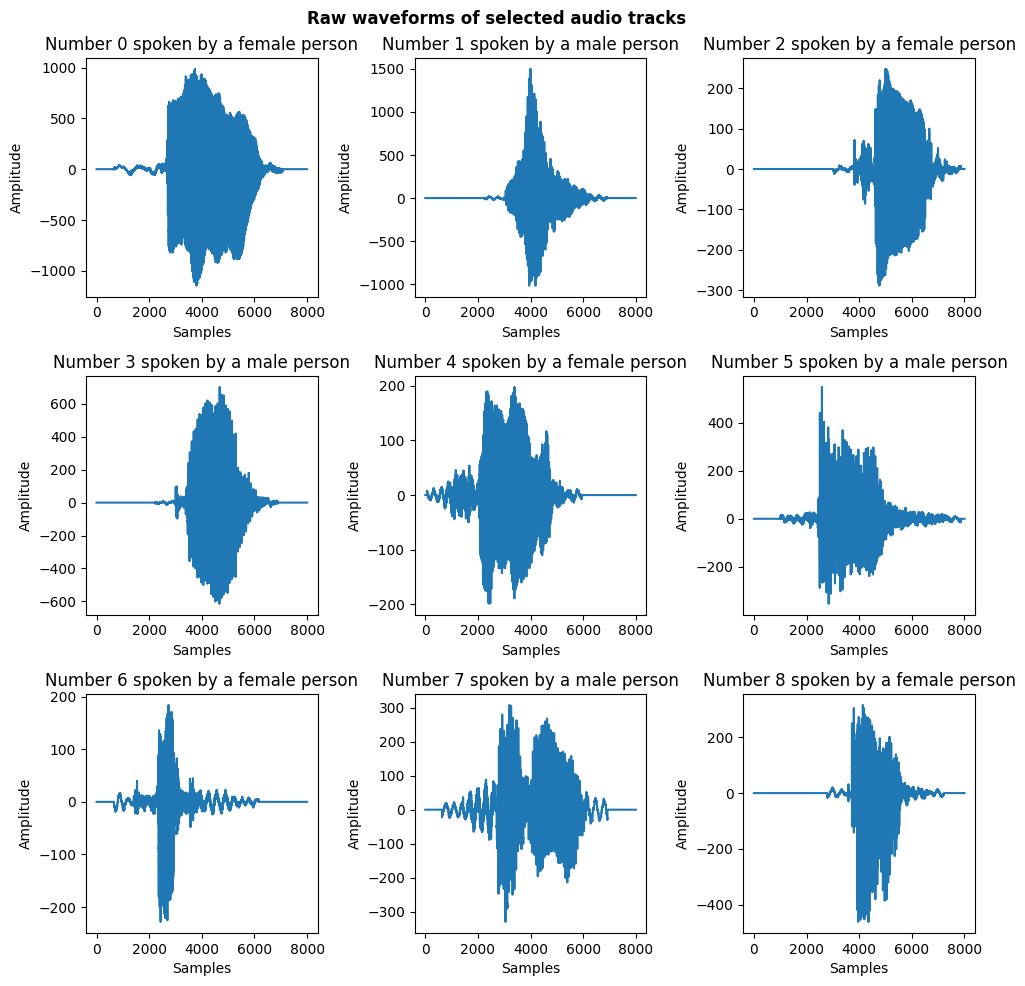

In [ ]:
# Let's look at the data.
# The code below takes the same samples for the 0-9 digits by females and males
# and display the waveforms asscociated with each of the selected audio files.


gender_ = 0
fig1, axs1 = plt.subplots(3, 3, figsize=(10, 10))

# iterating through the digits 0-9
for i, ax in zip(range(0, 10), axs1.ravel()):
    # we want to show some variety in the genders, so we are alternating genders
    # and seeking the next sample with correct gender/digit
    gender_ = 1 - gender_
    if len(np.intersect1d(np.where(y_num == i)[0], np.where(y_gender == gender_)[0])) == 0:
        continue
    index_to_show = np.intersect1d(np.where(y_num == i)[0], np.where(y_gender == gender_)[0])[0]

    # extracting the waveform and the labels
    audio_track = x[index_to_show]
    num_speak = y_num[index_to_show]
    gender_spoke = y_gender[index_to_show]
    gender_spoke = 'male' if gender_spoke == 0 else 'female'

    # plotting
    ax.plot(
        list(range(1, 8000 + 1, 1)),
        audio_track,
    )
    ax.set_ylabel('Amplitude')
    ax.set_xlabel('Samples')
    ax.set_title(f'Number {num_speak} spoken by a {gender_spoke} person')

fig1.suptitle(
    'Raw waveforms of selected audio tracks',
    fontsize=12,
    weight='bold',
)
fig1.tight_layout(pad=1)

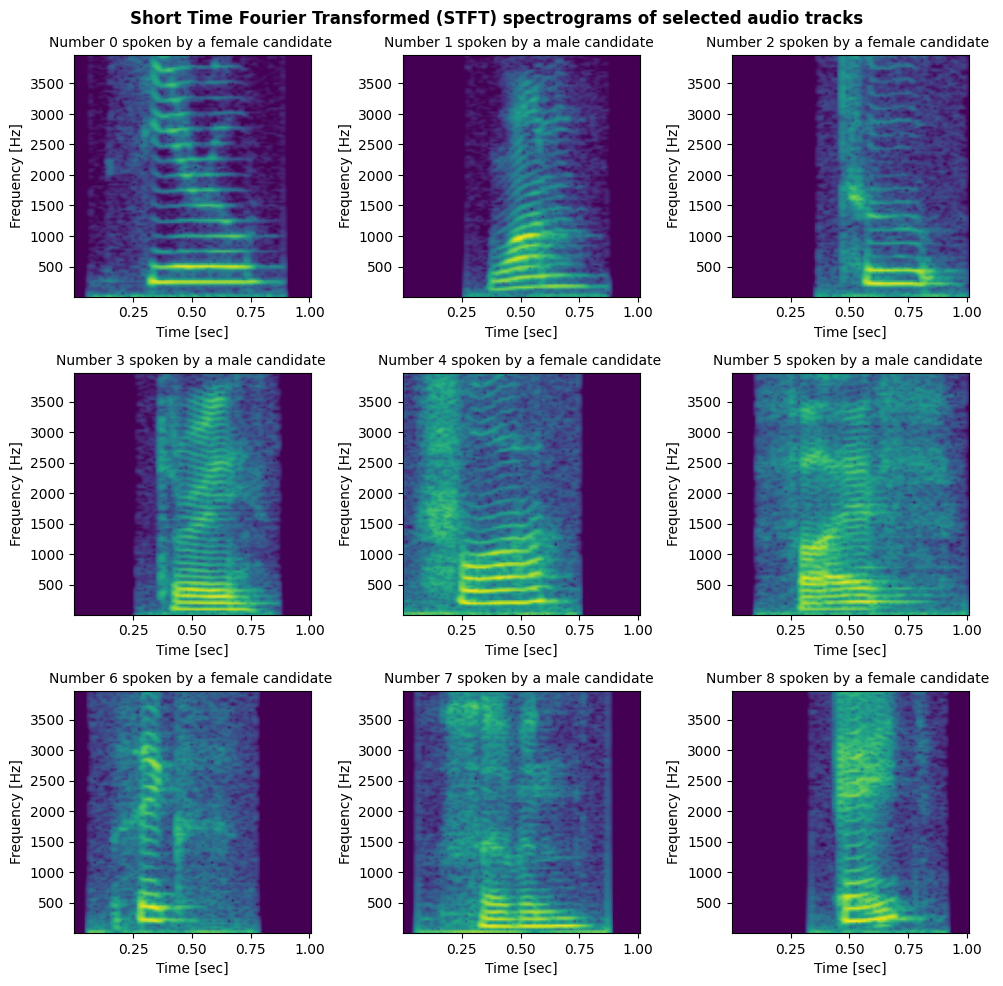

In [ ]:
# The code below takes the same samples for the 0-9 digits by females and males as in previous cell
# and display the spectrograms asscociated with the waveforms.

gender_ = 0
fig2, axs2 = plt.subplots(3, 3, figsize=(10, 10))

# iterating through the digits 0-9
for i, ax in zip(range(0, 10), axs2.ravel()):
    # we want to show different genders in this preview, so alternating genders
    gender_ = 1 - gender_
    # find the next sample with correct gender and digit
    if len(np.intersect1d(np.where(y_num == i)[0], np.where(y_gender == gender_)[0])) == 0:
        continue
    index_to_show = np.intersect1d(np.where(y_num == i)[0], np.where(y_gender == gender_)[0])[0]
    audio_track = x[index_to_show]
    num_speak = y_num[index_to_show]
    gender_spoke = y_gender[index_to_show]
    gender_spoke = 'male' if gender_spoke == 0 else 'female'
    # the spectrogram is computed through the use of the Short Time Fourier Transform (STFT)
    # see https://en.wikipedia.org/wiki/Short-time_Fourier_transform
    f, t, Zxx = scipy.signal.stft(audio_track, 8000, nperseg=455, noverlap=393, window='hann')
    Zxx_ = np.abs(Zxx[0:227, 2:-1])
    Zxx_ = np.atleast_3d(Zxx_).transpose(2,0,1)
    # after the STFT, the spectrogram is simply computed by taking the amplitude of the Fourier coefficients.
    Zxx_ = librosa.amplitude_to_db(Zxx_, ref=np.max)

    #
    f_, t_ = f[:227], t[:227]

    # to be able to fit everything in memory, we'll resize the spectrogram to images of size 128x128
    # this is not strictly necessary here, but when we try to load the entire dataset in memory, that will be
    # useful.
    f_ = resize(f_, (128, ))
    t_ = resize(t_, (128, ))
    Zxx_ = resize(Zxx_, (1, 128, 128))

    ax.set_title(f'Number {num_speak} spoken by a {gender_spoke} candidate ', fontsize=10)
    ax.pcolormesh(t_, f_, Zxx_[0, :, :], shading='gouraud')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')

fig2.suptitle(
    'Short Time Fourier Transformed (STFT) spectrograms of selected audio tracks',
    fontsize=12,
    weight='bold',
)
fig2.tight_layout(pad=1)

In [ ]:
# our usual useful functions

class PlotLossAccuracy(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.losses = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(int(self.i))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

        self.i += 1

        clear_output(wait=True)
        plt.figure(figsize=(16, 6))
        plt.plot([1, 2])
        plt.subplot(121)
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="validation loss")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.title('Model Loss')
        plt.legend()
        plt.subplot(122)
        plt.plot(self.x, self.acc, label="training accuracy")
        plt.plot(self.x, self.val_acc, label="validation accuracy")
        plt.legend()
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.title('Model Accuracy')
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show();


def save_model_to_disk(model, filename_base):
    # save model and weights (don't change the filenames)
    model_json = model.to_json()
    with open(filename_base + ".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(f"{filename_base}.h5")
    print(f"Saved model to {filename_base}.json and weights to {filename_base}.h5")

### The problem

You have two tasks:

1. Train two neural nets taking in _raw waveforms_ and predicting either the digit or the gender. The input waveform should be treated as an 1-dimentional-list with a shape of (8000, 1). Individual models should be trained for each task listed below:

  - Task 1A. **Classification of Gender**: the output is a keras catergorised vector that has a shape of (2, 1). For example, [0, 1] indicates class 2 which represents a waveform from a female candidate.
  - Task 1B. **Classification of Spoken Number**: the output is a keras categorised vector that has a shape of (10, 1). For example, [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] indicates class 3 which represents a waveform of spoken number 2.

2. Train the neural nets, this time taking the spectrograms as an input. This preprocessing step is commonly considered as a good embedding for representing the audio signal. The spectrograms should be standardised (through cropping) with a shape of [128, 128, 1] (see visualisation sample code above).

  - Task 2A. **Classification of Gender**: the output is a keras categorised vector that has a shape of (2, 1). For example, [0, 1] indicates class 2 which represents a waveform from a female candidate.
  - Task 2B. **Classification of Spoken Number**: the output is a keras categorised vector that has a shape of (10, 1). For example, [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] indicates class 3 which represents a waveform of spoken number 2.

---

**IMPORTANT**

For Task 1A, your model should be saved and submitted with the name: **'waveform_gender_model'**

For Task 1B, your model should be saved and submitted with the name: **'waveform_digit_model'**

For Task 2A, your model should be saved and submitted with the name: **'spectrogram_gender_model'**

For Task 2B, your model should be saved and submitted with the name: **'spectrogram_digit_model'**


In [ ]:

import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
# Modifications of the shape of x from [25000 x 8000 ] to [25000 x 8000 x 1]

#x_task1 = x[:,:,np.newaxis]


[2500 2500 2500 2500 2500 2500 2500 2500 2500 2500]


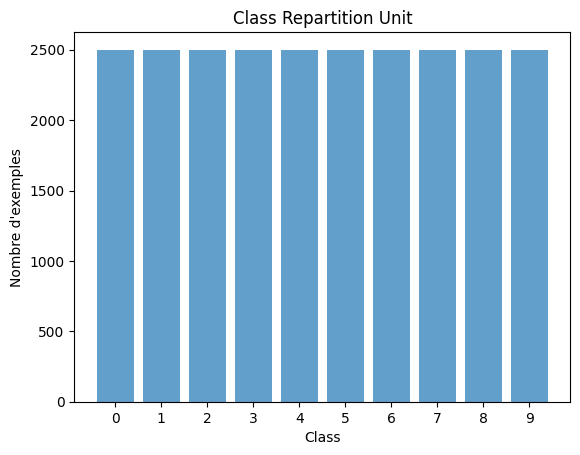

[20000  5000]


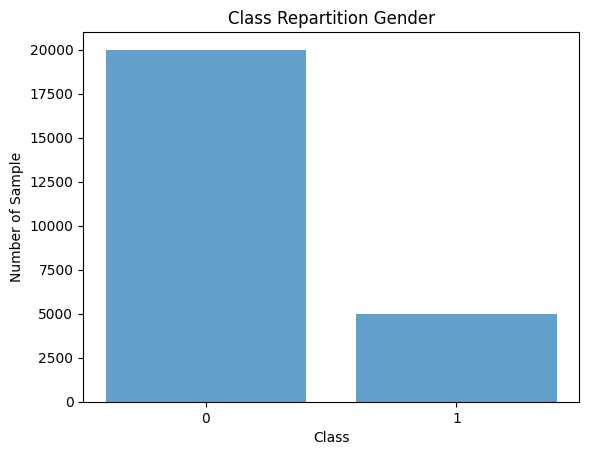

In [ ]:
# Calculate distribution of classes
classes, counts = np.unique(y_num, return_counts=True)
print(counts)
# Plot bar chart of class distribution
plt.bar(classes, counts, align='center', alpha=0.7)
plt.xticks(classes)
plt.xlabel('Class')
plt.ylabel('Nombre d\'exemples')
plt.title('Class Repartition Unit')
plt.show()
classes, counts = np.unique(y_gender, return_counts=True)
print(counts)

# Plot bar chart of class distribution
plt.bar(classes, counts, align='center', alpha=0.7)
plt.xticks(classes)
plt.xlabel('Class')
plt.ylabel('Number of Sample')
plt.title('Class Repartition Gender')
plt.show()

In [ ]:
# Task 1A: Gender Classisation on Waveforms

# Construct our neural networks here
model_1A = models.Sequential()
model_1A.add(layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(8000, 1)))
model_1A.add(layers.MaxPooling1D(pool_size=2))
model_1A.add(layers.Conv1D(64, kernel_size=3, activation='relu'))
model_1A.add(layers.MaxPooling1D(pool_size=2))
model_1A.add(layers.Conv1D(64, kernel_size=3, activation='relu'))
model_1A.add(layers.MaxPooling1D(pool_size=2))
model_1A.add(layers.Conv1D(64, kernel_size=3, activation='relu'))
model_1A.add(layers.MaxPooling1D(pool_size=2))
model_1A.add(layers.Conv1D(32, kernel_size=3, activation='relu'))
model_1A.add(layers.MaxPooling1D(pool_size=2))

model_1A.add(layers.Flatten())

model_1A.add(layers.Dense(128, activation='relu'))
model_1A.add(layers.Dropout(0.2))
model_1A.add(layers.Dense(128, activation='relu'))
model_1A.add(layers.Dropout(0.2))
model_1A.add(layers.Dense(128, activation='relu'))
model_1A.add(layers.Dense(2, activation='softmax'))


opt = keras.optimizers.legacy.Adam(lr=0.001, decay=1e-6,)


# setup the optimisation strategy, compile with loss, optimizer and the metric approppriat
model_1A.compile(optimizer=opt,
              loss='categorical_crossentropy', # we can use 'sparse_categorical_crossentropy' for one hot encoding like here
              metrics=['accuracy'])


model_1A.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 7998, 32)          128       
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 3999, 32)          0         
 ng1D)                                                           
                                                                 
 conv1d_11 (Conv1D)          (None, 3997, 64)          6208      
                                                                 
 max_pooling1d_11 (MaxPooli  (None, 1998, 64)          0         
 ng1D)                                                           
                                                                 
 conv1d_12 (Conv1D)          (None, 1996, 64)          12352     
                                                                 
 max_pooling1d_12 (MaxPooli  (None, 998, 64)          

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# y_gender_1 =  y_gender_1[:,:,np.newaxis]
# x = x[:,:,np.newaxis]
# print(y_gender_1.shape)

(25000, 2, 1)


In [ ]:
## Spilt Train and Val

X_train, X_validation, Y_train, Y_validation = skl.model_selection.train_test_split(x, y_gender_1, test_size=.2, random_state=seed)

print(y_gender_1.shape)
print(x.shape)
print(X_train.shape)
print(Y_train.shape)
print(X_validation.shape)
print(Y_validation.shape)

print(np.unique(y_gender_1))


(25000, 2)
(25000, 8000)
(20000, 8000)
(20000, 2)
(5000, 8000)
(5000, 2)
[0. 1.]


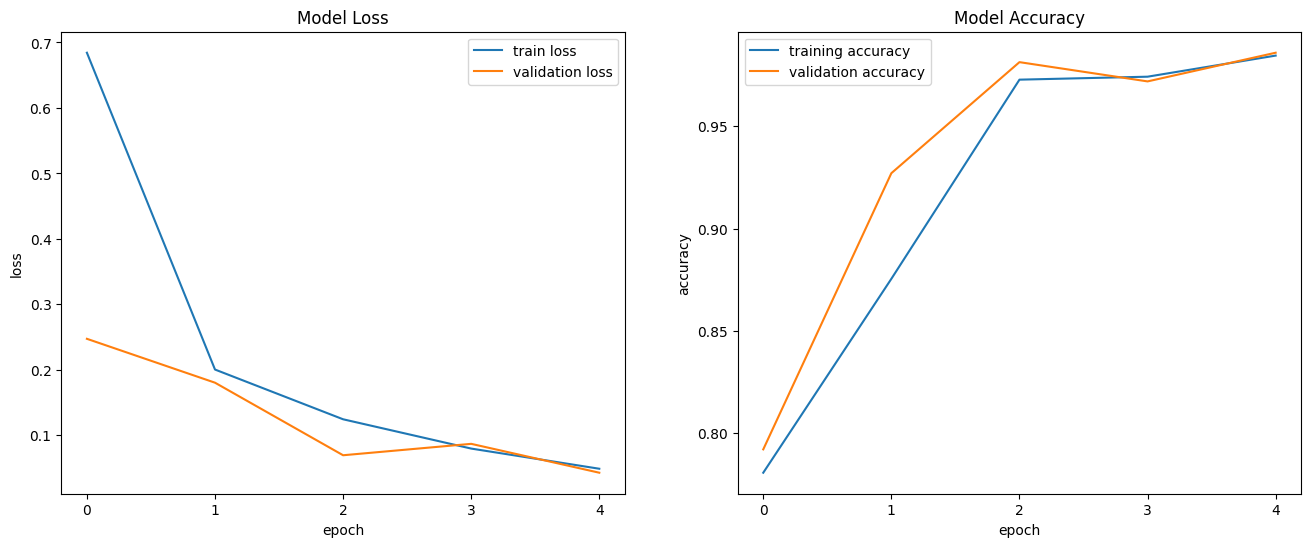

20/20 [==============================] - 12s 585ms/step - loss: 0.0489 - accuracy: 0.9844 - val_loss: 0.0428 - val_accuracy: 0.9858


In [ ]:
pltCallBack = PlotLossAccuracy()

def scheduler(epoch, lr):
  if epoch == 50 or epoch == 100:
    return lr/10
  else :
    return lr


reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)


# and train
model_1A.fit(X_train, Y_train,
          batch_size=1024, epochs=5,
          validation_data=(X_validation, Y_validation),
          callbacks=[pltCallBack])


In [ ]:
#Save model
save_model_to_disk(model_1A, 'waveform_gender_model')

Saved model to waveform_gender_model.json and weights to waveform_gender_model.h5


[20000 20000]
[5000 5000]


In [ ]:
# Nombre total de classes (taille de l'array)


# num_classes = 10

# nbr_lig = y_num.shape[0]

# # One-hot encoding
# one_hot_encoded = np.zeros((nbr_lig, num_classes))
# one_hot_encoded[np.arange(nbr_lig), y_num] = 1

# print(one_hot_encoded)
# print(one_hot_encoded.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
(25000, 10)


In [ ]:
# `one_hot_encoded = one_hot_encoded[:,:,np.newaxis]
# print(one_hot_encoded.shape)



(25000, 10, 1)


In [ ]:
# one_hot_encoded = np.transpose(one_hot_encoded, (0, 2, 1))
# print(one_hot_encoded.shape)


(25000, 10, 1)


In [ ]:
# Task 1B: Digit Classisation on Waveforms

model_1B = models.Sequential()

model_1B.add(layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(8000, 1)))
model_1B.add(layers.MaxPooling1D(pool_size=2))
model_1B.add(layers.Conv1D(64, kernel_size=3, activation='relu'))
model_1B.add(layers.MaxPooling1D(pool_size=2))
model_1B.add(layers.Conv1D(64, kernel_size=3, activation='relu'))
model_1B.add(layers.MaxPooling1D(pool_size=2))
model_1B.add(layers.Conv1D(64, kernel_size=3, activation='relu'))
model_1B.add(layers.MaxPooling1D(pool_size=2))
model_1B.add(layers.Conv1D(32, kernel_size=3, activation='relu'))
model_1B.add(layers.MaxPooling1D(pool_size=2))

# Flatten for the FC (fully connected)
model_1B.add(layers.Flatten())

model_1B.add(layers.Dense(128, activation='relu'))
model_1B.add(layers.Dropout(0.2))
model_1B.add(layers.Dense(128, activation='relu'))
model_1B.add(layers.Dropout(0.2))
model_1B.add(layers.Dense(128, activation='relu'))
model_1B.add(layers.Dense(10, activation='softmax'))

model_1B.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Utilisez 'sparse_categorical_crossentropy' si vos étiquettes de classe sont des entiers
              metrics=['accuracy'])


model_1B.summary()


#model_1B = # Figure this out
#save_model_to_disk(model_1B, 'waveform_digit_model')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 7998, 32)          128       
                                                                 
 max_pooling1d_20 (MaxPooli  (None, 3999, 32)          0         
 ng1D)                                                           
                                                                 
 conv1d_21 (Conv1D)          (None, 3997, 64)          6208      
                                                                 
 max_pooling1d_21 (MaxPooli  (None, 1998, 64)          0         
 ng1D)                                                           
                                                                 
 conv1d_22 (Conv1D)          (None, 1996, 64)          12352     
                                                                 
 max_pooling1d_22 (MaxPooli  (None, 998, 64)          

In [ ]:
X_train_1b, X_validation_1b, Y_train_1b, Y_validation_1b = skl.model_selection.train_test_split(x, y_num_1, test_size=.2)

# print(one_hot_encoded.shape)
# print(x_task1.shape)
print(X_train_1b.shape)
print(Y_train_1b.shape)
print(X_validation_1b.shape)
print(Y_validation_1b.shape)

# print(np.unique(one_hot_encoded))


(20000, 8000)
(20000, 10)
(5000, 8000)
(5000, 10)


In [ ]:
pltCallBack = PlotLossAccuracy()

def scheduler(epoch, lr):
  if epoch == 30 or epoch == 100:
    return lr/10
  else :
    return lr


reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

# and train
model_1B.fit(X_train_1b, Y_train_1b,
          batch_size=1024, epochs=50,
          validation_data=(X_validation_1b, Y_validation_1b),
          callbacks=[pltCallBack,reduce_lr])




Epoch 1/50
 6/20 [========>.....................] - ETA: 7s - loss: 6.5396 - accuracy: 0.1071

KeyboardInterrupt: ignored

In [ ]:
#Save Model
save_model_to_disk(model_1B, 'waveform_digit_model')

Saved model to waveform_digit_model.json and weights to waveform_digit_model.h5


In [ ]:
# Build Spectrogram

 # The code below takes the same samples for the 0-9 digits by females and males as in previous cell
# and display the spectrograms asscociated with the waveforms.

#fig2, axs2 = plt.subplots(3, 3, figsize=(10, 10))

x_spectrogram = []

# iterating through the digits 0-9
for audio_track in x:

    # the spectrogram is computed through the use of the Short Time Fourier Transform (STFT)
    # see https://en.wikipedia.org/wiki/Short-time_Fourier_transform
    f, t, Zxx = scipy.signal.stft(audio_track, 8000, nperseg=455, noverlap=393, window='hann')
    Zxx_ = np.abs(Zxx[0:227, 2:-1])
    Zxx_ = np.atleast_3d(Zxx_).transpose(2,0,1)
    # after the STFT, the spectrogram is simply computed by taking the amplitude of the Fourier coefficients.
    Zxx_ = librosa.amplitude_to_db(Zxx_, ref=np.max)

    #
    f_, t_ = f[:227], t[:227]

    # to be able to fit everything in memory, we'll resize the spectrogram to images of size 128x128
    # this is not strictly necessary here, but when we try to load the entire dataset in memory, that will be
    # useful.
    f_ = resize(f_, (128, ))
    t_ = resize(t_, (128, ))
    Zxx_ = resize(Zxx_, (1,128, 128))
    x_spectrogram.append(Zxx_)



In [ ]:
# Stack all the spectrogram

x_spectrogram = np.vstack(x_spectrogram)
print(x_spectrogram.shape)

(25000, 128, 128)


In [ ]:
# Task 2A: Gender Classisation on Spectrograms
# first we'll need to convert all waveforms to spectrogram (see sample code in prev cell)

# Construct our neural networks here


model_2A = models.Sequential()

model_2A.add(layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(128, 128)))
model_2A.add(layers.MaxPooling1D(pool_size=2))
model_2A.add(layers.Conv1D(64, kernel_size=3, activation='relu'))
model_2A.add(layers.MaxPooling1D(pool_size=2))
model_2A.add(layers.Conv1D(64, kernel_size=3, activation='relu'))
model_2A.add(layers.MaxPooling1D(pool_size=2))
model_2A.add(layers.Conv1D(64, kernel_size=3, activation='relu'))
model_2A.add(layers.MaxPooling1D(pool_size=2))
model_2A.add(layers.Conv1D(32, kernel_size=3, activation='relu'))
model_2A.add(layers.MaxPooling1D(pool_size=2))

model_2A.add(layers.Flatten())
model_2A.add(layers.Dense(128, activation='relu'))
model_2A.add(layers.Dropout(0.2))
model_2A.add(layers.Dense(128, activation='relu'))
model_2A.add(layers.Dropout(0.2))
model_2A.add(layers.Dense(128, activation='relu'))
model_2A.add(layers.Dense(2, activation='softmax'))

model_2A.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Utilisez 'sparse_categorical_crossentropy' si vos étiquettes de classe sont des entiers
              metrics=['accuracy'])



In [ ]:
X_train_2a, X_validation_2a, Y_train_2a, Y_validation_2a = skl.model_selection.train_test_split(x_spectrogram, y_gender_1, test_size=.2, random_state=seed)

#print(one_hot_encoded.shape)
# print(x_task1.shape)
print(X_train_2a.shape)
print(Y_train_2a.shape)
print(X_validation_2a.shape)
print(Y_validation_2a.shape)

(20000, 128, 128)
(20000, 2)
(5000, 128, 128)
(5000, 2)


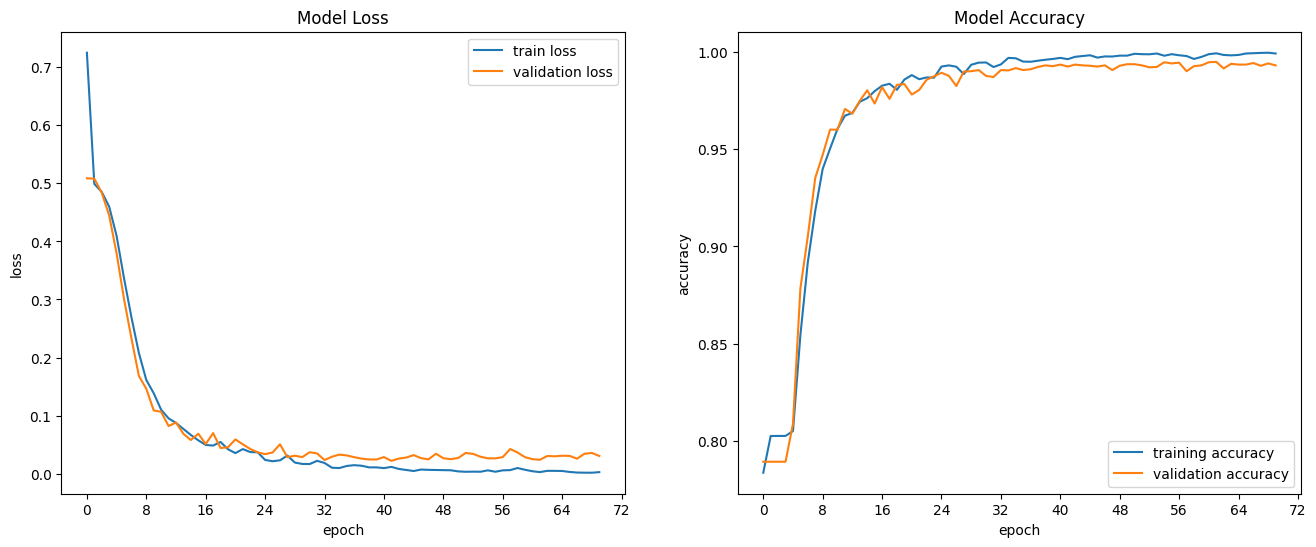

20/20 [==============================] - 2s 85ms/step - loss: 0.0026 - accuracy: 0.9991 - val_loss: 0.0305 - val_accuracy: 0.9930


In [ ]:
pltCallBack = PlotLossAccuracy()

def scheduler(epoch, lr):
  if epoch == 50 or epoch == 100:
    return lr/10
  else :
    return lr


reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)


# and train
model_2A.fit(X_train_2a, Y_train_2a,
          batch_size=1024, epochs=70,
          validation_data=(X_validation_2a, Y_validation_2a),
          callbacks=[pltCallBack])

In [ ]:
# Save Model
save_model_to_disk(model_2A, 'spectrogram_gender_model')

Saved model to spectrogram_gender_model.json and weights to spectrogram_gender_model.h5


In [ ]:
# Task 2B: Digit Classisation on Spectrograms
# first we'll need to convert all waveforms to spectrogram (see sample code in prev cell)

# Construct our neural networks here


model_2B = models.Sequential()
model_2B.add(layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(128, 128)))
model_2B.add(layers.MaxPooling1D(pool_size=2))
model_2B.add(layers.Conv1D(64, kernel_size=3, activation='relu'))
model_2B.add(layers.MaxPooling1D(pool_size=2))
model_2B.add(layers.Conv1D(64, kernel_size=3, activation='relu'))
model_2B.add(layers.MaxPooling1D(pool_size=2))
model_2B.add(layers.Conv1D(64, kernel_size=3, activation='relu'))
model_2B.add(layers.MaxPooling1D(pool_size=2))
model_2B.add(layers.Conv1D(32, kernel_size=3, activation='relu'))
model_2B.add(layers.MaxPooling1D(pool_size=2))

model_2B.add(layers.Flatten())
model_2B.add(layers.Dense(128, activation='relu'))
model_2B.add(layers.Dropout(0.2))
model_2B.add(layers.Dense(128, activation='relu'))
model_2B.add(layers.Dropout(0.2))
model_2B.add(layers.Dense(128, activation='relu'))
model_2B.add(layers.Dense(10, activation='softmax'))

model_2B.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])




In [ ]:
X_train_2b, X_validation_2b, Y_train_2b, Y_validation_2b = skl.model_selection.train_test_split(x_spectrogram, y_num_1, test_size=.2, random_state=seed)

#print(one_hot_encoded.shape)
# print(x_task1.shape)
print(X_train_2b.shape)
print(Y_train_2b.shape)
print(X_validation_2b.shape)
print(Y_validation_2b.shape)

(20000, 128, 128)
(20000, 10)
(5000, 128, 128)
(5000, 10)


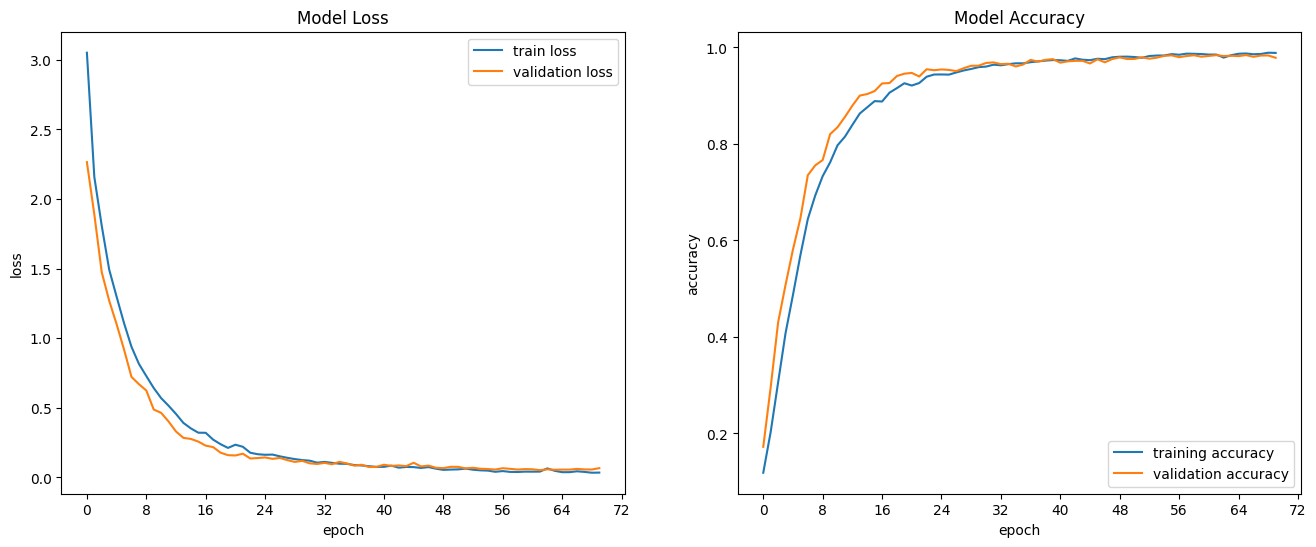

20/20 [==============================] - 2s 92ms/step - loss: 0.0352 - accuracy: 0.9887 - val_loss: 0.0670 - val_accuracy: 0.9786


In [ ]:
pltCallBack = PlotLossAccuracy()

def scheduler(epoch, lr):
  if epoch == 50 or epoch == 100:
    return lr/10
  else :
    return lr


reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)


# and train
model_2B.fit(X_train_2b, Y_train_2b,
          batch_size=1024, epochs=70,
          validation_data=(X_validation_2b, Y_validation_2b),
          callbacks=[pltCallBack])

In [ ]:
save_model_to_disk(model_2B, 'spectrogram_digit_model')

Saved model to spectrogram_digit_model.json and weights to spectrogram_digit_model.h5
